In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import unidecode
import string
import random
import time
import math
import os
import argparse
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

C:\Users\joska\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reading and un-unicode-encoding data

all_characters = string.printable
n_characters = len(all_characters)

def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)

# you know what it does, keep in mind it is not a dict tho :)
def create_dictionary(text):
    special_characters = [' ', ':', '\n', ',', '.', '?', "'", ';', '!', '-', '&']

    dictionary = []
    dataset = []

    j = 0
    for i in range(len(text)):
        char = text[i]
        if char in special_characters:
            word = text[j:i]
            if i == j:
                word = text[j:i+1]
                
            if char not in dictionary:
                dictionary.append(char)
                
            if word not in dictionary:
                dictionary.append(word)
                
            if i != j:
                charInd = dictionary.index(char)
                wordInd = dictionary.index(word)
                dataset.append([wordInd])
                dataset.append([charInd])
            else:
                wordInd = dictionary.index(word)
                dataset.append([wordInd])
            
            j = i+1
        continue

    return dictionary, dataset

    
# Turning a string into a tensor

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = dictionary.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [3]:
filename = "shakespeare.txt"
text = read_file(filename)[0]
dictionary, dataset = create_dictionary(text)


In [4]:
class WordRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(WordRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, input, hidden):
        encoded = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [5]:
# finds all whole words in the random chunk?
def findChunk(start_index, chunk_len):
    file_chunk = file[start_index:]
    # print("len(file_chunk)",len(file_chunk))
    special_characters = [' ', ':', '\n', ',', '.', '?', "'", ';', '!', '-', '&']
    chunk = []
    i = 0
    j = 0

    while len(chunk) <= chunk_len:
    # for i in range(len(text)):
        # print("i",i)
        char = file_chunk[i]
        # print("char i",char,i)
        if char in special_characters:
            word = file_chunk[j:i]
            # print("if",word)
            if i == j:
                word = file_chunk[j:i+1]
                
            if char in dictionary:
                # print("found char:",char)
                chunk.append(char)
                
            if word in dictionary:
                # print("found word:",word)
                chunk.append(word)
            
            j = i+1
        i += 1
        continue

    if len(chunk) > chunk_len+1:
        chunk.pop()

    return chunk

In [6]:
def random_training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, file_len - chunk_len*10)
        # end_index = start_index + chunk_len + 1
        chunk = findChunk(start_index, chunk_len)
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    # print("inp",inp)
    # print("target",target)
    inp = Variable(inp)
    target = Variable(target)
    if cuda:
        inp = inp.cuda()
        target = target.cuda()
    return inp, target

def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    if cuda:
        hidden = hidden.cuda()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
    # for c in [0]:

        # print ("inp[:,c]:", inp[:,c])
        # print ("hidden:",hidden)

        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

def save():
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    torch.save(decoder, save_filename)
    print('Saved as %s' % save_filename)

In [14]:
# def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
#     hidden = decoder.init_hidden(1)
#     prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

#     if cuda:
#         hidden = hidden.cuda()
#         prime_input = prime_input.cuda()
#     predicted = prime_str

#     # Use priming string to "build up" hidden state
#     for p in range(len(prime_str) - 1):
#         _, hidden = decoder(prime_input[:,p], hidden)
        
#     inp = prime_input[:,-1]
    
#     for p in range(predict_len):
#         output, hidden = decoder(inp, hidden)
        
#         # Sample from the network as a multinomial distribution
#         output_dist = output.data.view(-1).div(temperature).exp()
#         top_i = torch.multinomial(output_dist, 1)[0]

#         # Add predicted character to string and use as next input
#         predicted_char = all_characters[top_i]
#         predicted += predicted_char
#         inp = Variable(char_tensor(predicted_char).unsqueeze(0))
#         if cuda:
#             inp = inp.cuda()

#     return predicted

In [17]:
def sentence_tensor(string):
    word_tensor = []
    special_characters = [' ', ':', '\n', ',', '.', '?', "'", ';', '!', '-', '&']
    j = 0
    i = 0
    while i < len(string):
        char = string[i]
        if char in special_characters:
            word = 0
            if i == j:
                word = string[j:i+1]
                wordInd = dictionary.index(word)
                word_tensor.append(wordInd)
            else:
                word = string[j:i]
                wordInd = dictionary.index(word)
                charInd = dictionary.index(char)
                word_tensor.append(wordInd)
                word_tensor.append(charInd)
            
            j = i+1
        i += 1
    
    if(j != i):
        word = string[j:i+1]
        wordInd = dictionary.index(word)
        word_tensor.append(wordInd)
    tensor = torch.tensor(word_tensor).long()
    return tensor

In [27]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(sentence_tensor(prime_str).unsqueeze(1))
    predicted = prime_str
    
    # Use priming string to "build up" hidden state
    for p in range(len(prime_input) - 1):
        inp = torch.unsqueeze(prime_input[p,:], dim=1)
        out, hidden = decoder(inp, hidden)
    
    #hidden = (Variable(hidden[0].detach().to(device)), Variable(hidden[1].detach().to(device)))
    
    inp = torch.unsqueeze(prime_input[-1,:], dim=1)
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_word = dictionary[top_i]
        predicted += predicted_word
        inp = Variable(sentence_tensor(predicted_word).unsqueeze(1))
       
        if cuda:
            inp = inp.cuda()

    return predicted

In [31]:
# define args
filename = "shakespeare.txt"
n_epochs = 2000
model = "gru"
print_every = 100
hidden_size = 50
n_layers = 2
learning_rate = 0.01
chunk_len = 50
batch_size = 100
shuffle = True
cuda = False

n_characters = len(dictionary)

file, file_len = read_file(filename)

# Initialize models and start training
decoder = WordRNN(
    n_characters,
    hidden_size,
    n_characters,
    model=model,
    n_layers=n_layers,
)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


Training for 2000 epochs...


  5%|▌         | 100/2000 [02:25<46:12,  1.46s/it]

 25s (100 5%) 4.2922]
Whofasts 
medo 
 to  
 ' :,'     thy  
 ' 
   Bianca

 ' tread  ours ,   :thee 
 : 
     
    '  :
  'slander allPOLIXENES 
       ,
  will   

 
 



 10%|█         | 200/2000 [04:48<45:15,  1.51s/it]

 48s (200 10%) 3.8726]
WhocousinmatchesclimeSlanderingstill:
I





he
   with 
    offront  

 ' Than  ,        the    too' ?
 I,to
  ,    I 
     . to,     the,do the'here 
      



 15%|█▌        | 300/2000 [07:12<41:15,  1.46s/it]

 12s (300 15%) 3.5170]
WhowaspishmusclesjudgmentSeeree   my not all.


 And is  'great the the my   come do I been is,boy   the with sir my the mind for

in my and they and shall of will Strong are,
   TYBALT of to   that a  



 20%|██        | 400/2000 [09:35<38:41,  1.45s/it]

 35s (400 20%) 3.3910]
WhoEdmundripestachingprecursorsunsaluteddiscontentedsickerspeak
 And to;love

And


disturb

  now common to the come are the their have and up the of, and I the;and   s from me foe so,lady


 

Rush By save a Marcius the his thee a his  



 25%|██▌       | 500/2000 [11:57<36:37,  1.46s/it]

 57s (500 25%) 3.3382]
WhorGrimmaltPreferwanedstricturetoo
   and,glittering   are Could !   for you,,   of on s how of be,gates


But   offence faint the your'our.


   me hast heart accusation and good::
   recompense a'::

 is the., 



 30%|███       | 600/2000 [14:20<33:59,  1.46s/it]

 20s (600 30%) 3.2159]
Whononabreastellhegibere e,

   upon to and s his me at. 
to d at how of her their.- To,nature

A



-



 Which mortal the him of the   to of I beseech.no
gods



 pardon his not affairs  



 35%|███▌      | 700/2000 [16:43<31:09,  1.44s/it]

 43s (700 35%) 3.2054]
WholowlyGalliaSilversprightfullycoxcombsveLombardyobsequiousremorselessee






:


-



 I not have,hell   Edward for some  !night

 Nay then of OF:man

 One thy ,leave   me OF here that so it,YORK
: found a,:
  ,sir    



 40%|████      | 800/2000 [19:03<28:36,  1.43s/it]

 3s (800 40%) 3.1548]
Whoendingrr cousin in and hath your thee of the :place

 as is the as the:away   keep Real.not





::








 O service kill I,king   but,ARIEL

   cunning thee not,regal


:


 No voice 



 45%|████▌     | 900/2000 [21:22<26:14,  1.43s/it]

 22s (900 45%) 3.0513]
WhopilgrimsHewgatheringrrcrosslycurrantsrn  ;white


For


 When we to at will an son the,free


 To after and the,youngest   thou shall his together upon what resolution the veins to for;king

 I the sovereignty d that title for to the face  



 50%|█████     | 1000/2000 [23:42<23:46,  1.43s/it]

 42s (1000 50%) 3.0799]
WhoMightwritingminionstragicalattendantfrivolousr   of,me   the jealousies have are make Till death our
not That to not not can of.dry




:


ISABELLA

O  !SICINIUS

 How been to and I service thou hold the son a'hundred ?word



'I  



 55%|█████▌    | 1100/2000 [26:00<20:56,  1.40s/it]

 0s (1100 55%) 2.9432]
WhogrindattentionUpbraiddestroyerrudesbydicedildosLoseellmlermrn as as,me   my so I one as have
ever That aged should the country to of say be to the virtuous.brother

 Did as from them,of   to discontented veil among and:marquess

 That take to a  



 60%|██████    | 1200/2000 [28:18<18:53,  1.42s/it]

 18s (1200 60%) 3.0418]
Whoetfeelsapoplexye

:hands

 A fence is so,mother   we I his,bones

 Were do with Clarence to,elder

Such   and eyes that are thy pronounce may they,let

 For a ear thy thou parts that forgot.WARWICK



  ,and   do  



 65%|██████▌   | 1300/2000 [30:37<16:28,  1.41s/it]

 37s (1300 65%) 2.9941]
Whodistributechoose  OF.repair



:GLOUCESTER

 O!, ' s fought it his:lord

  is my,friar   my love.MERCUTIO

:III



 For to to O,your  -hath for bargain good?lord



 Tell;joy   that wedded the'lords s shame 



 70%|███████   | 1400/2000 [32:55<14:03,  1.41s/it]

 55s (1400 70%) 2.9996]
WhoransomedmasquingLongemrn tisscathee.laugh



  OF:virtuous

 Most writ and a love of of,enter

 The life my
amazement Have that tell do me in as,hold

  with of Romeo my,me

  ?ways



 He OF:II

 I  



 75%|███████▌  | 1500/2000 [35:13<11:44,  1.41s/it]

 13s (1500 75%) 2.9709]
WhoploughOrestUpbraidmquiveringnagebrineadbutcheryadrr ;thee   the thine private,horseman   and his broth my
again To will I the.hour'   abet sums than lour
have had now the 
them Hath you on the heard,this

 make and are my 
pearl In,would 



 80%|████████  | 1600/2000 [37:32<09:24,  1.41s/it]

 32s (1600 80%) 2.9351]
Whosiegemindlessgreatestshearersetpailr
r Shall Grindstone they here thy.heat   I chance of
falling And set I gainst then Is slender,manner

 To dangerous I thou his privilege will of
sovereignty and tombs.dainty



 Second:CLIFFORD

 I Tis you Tis the ,best

 And 



 85%|████████▌ | 1700/2000 [39:50<07:02,  1.41s/it]

 50s (1700 85%) 2.9196]
Whoechoadornedunreasonableslyhowlingperfidiousacts ,

 He me the horror late'foreign
do O I have not lips'order .justice



 Second.waters



:BOLINGBROKE

 Go the Page
apron   Richmond my.crown



 No ,king   our old:MARCIUS

 But the hundred prithee  



 90%|█████████ | 1800/2000 [42:08<04:39,  1.40s/it]

 8s (1800 90%) 2.8636]
WhoForerunninggossipadplayingchidersrd How had out is from the king yet his body these a;day

 Than with from to but in life mirthful or!place

 To their again be I'heir   of a.dissemblers



:Servant

And

  Ay Clarence a gods you  



 95%|█████████▌| 1900/2000 [44:26<02:21,  1.42s/it]

 26s (1900 95%) 2.8558]
WhoInfusingmcerlawnsr  for me and.you





:MENENIUS

 I Tis sit to be of my'man s,lord

 Your if with wilt behind am his :queen

 KING and is and,lord

 And have by thou they take in to my;VINCENTIO

 



100%|██████████| 2000/2000 [46:44<00:00,  1.40s/it]

 44s (2000 100%) 2.8593]
WhoclapsseizedBegcreaturesbehalfsRheimswhosoravenousgainst .d



:LUCENTIO

 I,ll   to,will   made to as but to,more

 From the ,hast   it the
day  and but of to,served

 And,if   in then to,go   but they,thou  
I 

Saving...
Saved as shakespeare.pt


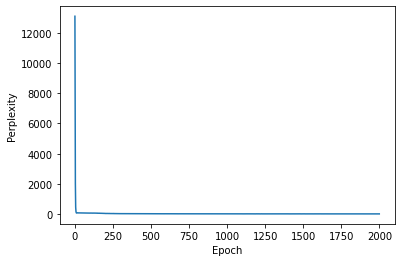

In [32]:

if cuda:
    decoder.cuda()

start = time.time()
all_losses = []
loss_avg = 0

perplexities = []

try:
    print("Training for %d epochs..." % n_epochs)
    for epoch in tqdm(range(1, n_epochs + 1)):
        loss = train(*random_training_set(chunk_len, batch_size))
        loss_avg += loss
        perplexities.append(math.exp(loss))

        if epoch % print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
            print(generate(decoder, 'Who', 100, cuda=cuda), '\n')

    print("Saving...")
    save()

except KeyboardInterrupt:
    print("Saving before quit...")
    save()


plt.plot(perplexities)
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.show()

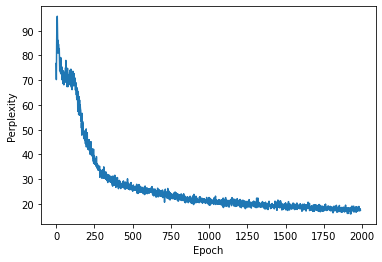

In [33]:
# if we ignore some of the first epochs we get a much clearer graph
plt.plot(perplexities[10:])
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.show()

In [36]:
import string
import random

def randomString(len):
    s = ""
    for i in range(len):
        s = s + random.choice(string.printable)
    return s

In [78]:
decoder = torch.load("shakespeare.pt")

with open('task4_the.txt', 'w') as f:
    for i in range(3):
        prime_string = "The"
        f.write("====== Prime string: " +prime_string + " ======\n")
        f.write(generate(decoder, prime_str=prime_string))
        f.write("\n\n")

In [79]:
with open('task4_dot.txt', 'w') as f:
    for i in range(3):
        prime_string = "."
        f.write("====== Prime string: " + prime_string +" ======\n")
        f.write(generate(decoder, prime_str=prime_string))
        f.write("\n\n")

In [80]:
with open('task4_which.txt', 'w') as f:
    for i in range(3):
        prime_string = "which is,"
        f.write("====== Prime string: " + prime_string +" ======\n")
        f.write(generate(decoder, prime_str=prime_string))
        f.write("\n\n")

In [81]:
with open('task4_blah.txt', 'w') as f:
    for i in range(3):
        prime_string = "blah blah blah"
        f.write("====== Prime string: "+ prime_string + " ======\n")
        f.write(generate(decoder, prime_str=prime_string))
        f.write("\n\n")

ValueError: 'blah' is not in list